In [1]:
import cv2 as cv
import matplotlib
from matplotlib import pyplot as plt
import os
import shutil   #used for removing the dir that are not empty

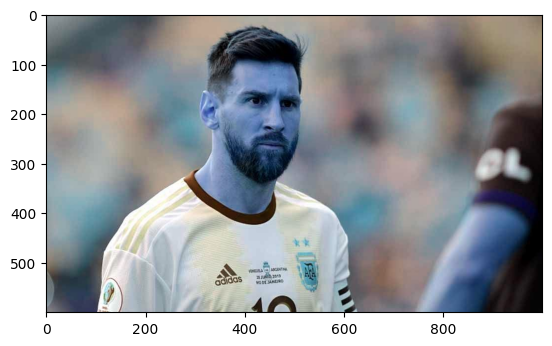

In [2]:
img = cv.imread(r'images_dataset\lionel_messi\190703-lionel-messi.jpg')
plt.imshow(img)

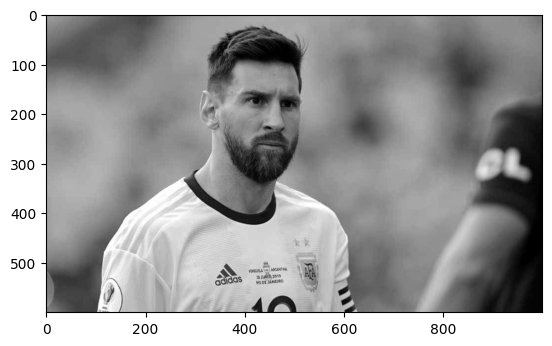

In [3]:
img_grey = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
plt.imshow(img_grey,cmap='gray')

In [4]:
face_cascade = cv.CascadeClassifier('opencv\haarcascades\haarcascade_frontalface_default.xml')
eye_cascade = cv.CascadeClassifier('opencv\haarcascades\haarcascade_eye.xml')
face = face_cascade.detectMultiScale(img_grey,1.3,5)
face

array([[356, 102, 205, 205]])

In [5]:
# x,y,h,w = face[0]

# imgg = cv.rectangle(img_grey,(x,y),(x+h,y+w),(255,0,0),2)
# plt.imshow(imgg)

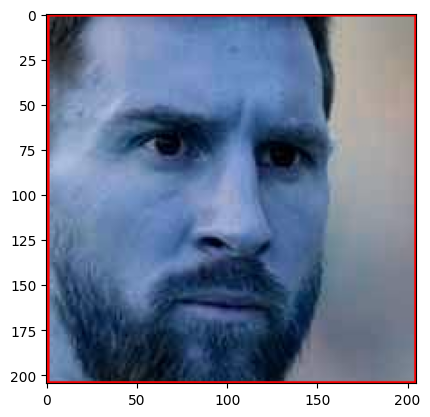

In [5]:
def convert():
    faces = face_cascade.detectMultiScale(img_grey,1.3,5)
    for (x,y,w,h) in faces:
        face_imge = cv.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
        roi_colo = face_imge[y:y+h,x:x+w]
        roi_gr = img_grey[y:y+h,x:x+w]
        eyes = eye_cascade.detectMultiScale(roi_gr)
        if len(eyes)>1:
            return roi_colo

cropped_Image_Original = convert()
plt.imshow(cropped_Image_Original,cmap='gray')
plt.show()

In [6]:
def faced_img(path):
    img1 = cv.imread(path)
    img_grey1 = cv.cvtColor(img1,cv.COLOR_BGR2GRAY)
    face1 = face_cascade.detectMultiScale(img_grey1,1.3,5)
    result = []
    for (x,y,w,h) in face1:
        colour_face = img1[y:y+h,x:x+w]
        gray_face = img_grey1[y:y+h,x:x+w]
        eyes = eye_cascade.detectMultiScale(gray_face)
        if len(eyes)>=2:
            result.append(colour_face)
    return result


# plt.imshow(faced_img(r'images_dataset\maria_sharapova\19102426-7520279-image-m-60_1569839081937.jpg'),cmap='gray')
#plt.imshow(faced_img(r'images_dataset\lionel_messi\7488bab50fd9441a43359ec299a8dad2.jpg')[1],cmap='gray')

In [7]:
path = r"D:\Python\Project2\backend\model\images_dataset"
cropped_folder = path + '/cropped_img'
if os.path.exists(cropped_folder):
    shutil.rmtree(cropped_folder)

img_dir = []
for entry in os.scandir(path):
    if entry.is_dir():
        img_dir.append(entry.path)
    
img_dir

['D:\\Python\\Project2\\backend\\model\\images_dataset\\lionel_messi',
 'D:\\Python\\Project2\\backend\\model\\images_dataset\\maria_sharapova',
 'D:\\Python\\Project2\\backend\\model\\images_dataset\\roger_federer',
 'D:\\Python\\Project2\\backend\\model\\images_dataset\\serena_williams',
 'D:\\Python\\Project2\\backend\\model\\images_dataset\\virat_kohli']

In [8]:
cropped_folder = path + '/cropped_img'

if os.path.exists(cropped_folder):
    shutil.rmtree(cropped_folder)
os.mkdir(cropped_folder)

In [9]:
cropped_img_dir = []
cel_file_name = {}

for img_di in img_dir:
    count  = 1
    celib = img_di.split('\\')[-1]
    cel_file_name[celib] = []
    print(celib)
    
    for entry in os.scandir(img_di):
        roi_color = faced_img(entry.path)
        if len(roi_color)>0:
            crop = cropped_folder + '/' + celib
            if not os.path.exists(crop):
                os.mkdir(crop)
                cropped_img_dir.append(crop)
                print("created folder",celib)
            for image in roi_color:
                cropped_file_name = celib + '_' + str(count) + ".png"
                cropped_file_path = crop + '/' + cropped_file_name
                cv.imwrite(cropped_file_path,image)
                cel_file_name[celib].append(cropped_file_path)
                count=count+1

lionel_messi
created folder lionel_messi
maria_sharapova
created folder maria_sharapova
roger_federer
created folder roger_federer
serena_williams
created folder serena_williams
virat_kohli
created folder virat_kohli


In [10]:
import numpy as np
import pywt

def wavelet(imagee,mode='haar',level=1):
    arrays = imagee

    arrays = cv.cvtColor(arrays,cv.COLOR_RGB2GRAY)
    arrays = np.float32(arrays)
    arrays/=255
    coeff =  pywt.wavedec2(arrays,mode,level)
    
    coeff_H = list(coeff)
    coeff_H[0] *=0
    
    arrays_H = pywt.waverec2(coeff_H,mode)
    arrays_H *=255
    arrays_H = np.uint8(arrays_H)
    
    return arrays_H
    

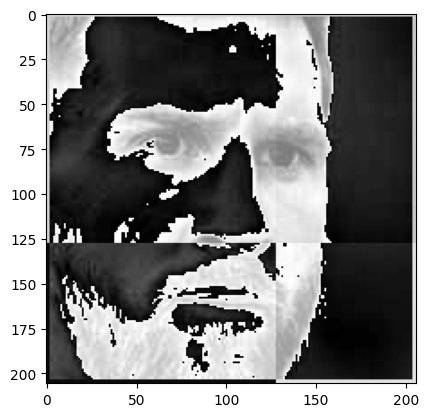

In [11]:
im_har = wavelet(cropped_Image_Original,'db1',5)
plt.imshow(im_har,cmap='gray')

In [12]:
celeb_name_encode={}
count =1
for keys in cel_file_name.keys():
    celeb_name_encode[keys]=count
    count=count+1
    
celeb_name_encode

{'lionel_messi': 1,
 'maria_sharapova': 2,
 'roger_federer': 3,
 'serena_williams': 4,
 'virat_kohli': 5}

In [ ]:
cel_file_name


In [13]:
x=[]
y=[]

for key,dirr in cel_file_name.items():
    for location in dirr:
        imagee=cv.imread(location)
        if imagee is None:
            continue
        imagee_resized = cv.resize(imagee,(32,32))
        wave_image = wavelet(imagee,'db1',5)
        wave_image_resized = cv.resize(wave_image,(32,32))
        resultant_img = np.vstack((imagee_resized.reshape(32*32*3,1),wave_image_resized.reshape(32*32,1)))
        x.append(resultant_img)
        y.append(celeb_name_encode[key])

In [14]:
len(y)

180

In [15]:
x = np.array(x).reshape(len(x),4096).astype(float)
x.shape

(180, 4096)

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline

x_train,x_test,y_train,y_test = train_test_split(x,y,train_size=0.8,random_state=10,shuffle=True)
len(y_train)

144

In [17]:
pipe = Pipeline([('scale',StandardScaler()),('predict',SVC(kernel='sigmoid',C=2,probability=True))])
pipe.fit(x_train,y_train)
pipe.score(x_test,y_test)

0.8333333333333334

In [18]:
print(classification_report(y_test,pipe.predict(x_test)))

              precision    recall  f1-score   support

           1       0.71      1.00      0.83         5
           2       1.00      0.83      0.91        12
           3       0.71      0.83      0.77         6
           4       1.00      0.71      0.83         7
           5       0.71      0.83      0.77         6

    accuracy                           0.83        36
   macro avg       0.83      0.84      0.82        36
weighted avg       0.87      0.83      0.84        36



In [19]:
from sklearn.model_selection import cross_val_score

np.mean(cross_val_score(Pipeline([('scale',StandardScaler()),('predict',SVC(kernel='sigmoid',C=2))]),x,y,cv=5))


0.8222222222222222

In [20]:
from sklearn.tree import DecisionTreeClassifier
np.mean(cross_val_score(Pipeline([('scale',StandardScaler()),('predict',DecisionTreeClassifier())]),x,y,cv=10))

0.6

In [21]:
from sklearn.ensemble import RandomForestClassifier
np.mean(cross_val_score(Pipeline([('scale',StandardScaler()),('predict',RandomForestClassifier())]),x,y,cv=10))

0.8111111111111111

In [22]:
from sklearn.linear_model import LogisticRegression
np.mean(cross_val_score(Pipeline([('scale',StandardScaler()),('predict',LogisticRegression())]),x,y,cv=10))

0.8722222222222221

In [23]:
bestmodel = Pipeline([('scale',StandardScaler()),('predict',LogisticRegression())])
bestmodel.fit(x_train,y_train)
bestmodel.score(x_test,y_test)

0.8888888888888888

In [24]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test,bestmodel.predict(x_test))
cm

array([[ 5,  0,  0,  0,  0],
       [ 0, 11,  1,  0,  0],
       [ 1,  0,  5,  0,  0],
       [ 0,  0,  1,  6,  0],
       [ 1,  0,  0,  0,  5]], dtype=int64)

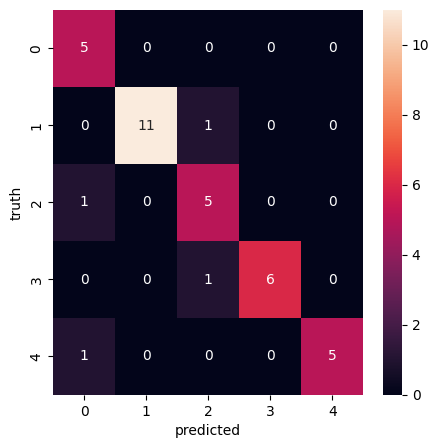

In [25]:
import seaborn as sn

plt.figure(figsize=(5,5))
sn.heatmap(cm,annot=True)
plt.xlabel('predicted')
plt.ylabel('truth')
plt.show()

In [26]:
import pickle

with open('face_recog_model.pickle','wb') as f:
    pickle.dump(bestmodel,f)

In [27]:
import joblib

joblib.dump(bestmodel,'face_recog_joblib.pkl')

['face_recog_joblib.pkl']

In [28]:
import json

with open ('class_dist.json','w') as f:
    f.write(json.dumps(celeb_name_encode))